## **Bioprospecting analysis 2.0**

#### In this Notebook we will used the data generated in the [Bioprospecting analysis 1.0](https://github.com/pereiramemo/bioprospecting/blob/main/notebooks/bioprospecting-1.0.ipynb)
#### The tasks are organized in the following sections:  
#### [**0. Set env**](#section0)
#### [**1. Explore the BGC class composition**](#section1)
#### [**2. Explore the BGC's taxonomic composition**](#section2)
#### [**3. Explore the BGC diversity**](#section3)
#### [**3. Assess the BGC novelty**](#section4)

<a id='section0'></a>
**0. Set env**

Load the libraries

In [213]:
library(tidyverse)
library(lubridate)
library(ggdendro)
library(ggpubr)
library(vegan)
options(dplyr.summarise.inform = FALSE)
setwd("/home/epereira/workspace/dev/new_atlantis/repos/bioprospecting/notebooks/workdir/")
source("/home/epereira/workspace/dev/new_atlantis/repos/bioprospecting/aux_scripts/get_season_north.R")
source("/home/epereira/workspace/dev/new_atlantis/repos/bioprospecting/aux_scripts/custom_rarefy.R")


Load the data

In [4]:
BGC_TBL <- read_tsv("outputs/bgc_abund/bgc_abund.tsv", 
                    col_names = F,
                    show_col_types = F)
colnames(BGC_TBL) <- c("sample", "seq_id", "edge", "bgc_class", "abund")

TAXA_TBL <- read_tsv("outputs/bgc_taxa/bgc_taxa_annot_lca_formatted.tsv", 
                     col_names = F,
                     show_col_types = F)
colnames(TAXA_TBL) <- c("sample", "seq_id", "tax_level", "tax_path")

METADATA_TBL <- read_csv("data/SOLA_metadata_extended.tsv",
                         col_names = T,
                         show_col_types = F)
METADATA_TBL$Season <- factor(get_season_north(METADATA_TBL$collection_date), 
                              levels = c("Winter", "Spring", "Summer", "Fall"))

<a id='section1'></a>
**1. Explore the BGC class composition**

First we have to collapse the BGC class abundance per sample.

In [181]:
BGC_TBL_coll <- BGC_TBL %>%
                group_by(sample, bgc_class) %>%
                summarize(abund = sum(abund)) %>%
                group_by(sample) %>%
                mutate(abund_rel = 100*abund/sum(abund)) %>%
                left_join(x =., 
                          y = METADATA_TBL %>% select(run_accession, collection_date),
                           by = c("sample" = "run_accession")) %>%
                ungroup %>%
                select(-sample) %>%
                mutate(Season = get_season_north(collection_date)) %>%
                mutate(collection_date = as.character(collection_date))

head(BGC_TBL_coll)

bgc_class,abund,abund_rel,collection_date,Season
<chr>,<dbl>,<dbl>,<chr>,<fct>
betalactone,1.014010,14.109479,2012-01-03,Winter
phosphonate,1.041835,14.496650,2012-01-03,Winter
resorcinol,1.011193,14.070280,2012-01-03,Winter
terpene,4.119691,57.323591,2012-01-03,Winter
betalactone,3.185653,23.041487,2012-02-21,Winter
hserlactone,1.068975,7.731779,2012-02-21,Winter


Let's see some basic stats:

In [182]:
bgc_class_n <- BGC_TBL_coll$bgc_class %>% unique %>% length
bgc_seqs_n <- BGC_TBL$seq_id %>% unique %>% length
bgc_complete_seqs_n <- sum(!BGC_TBL$edge)

cat(paste(rep("#",80), sep = "", collapse = ""), "\n")
cat(paste("Number of BGC classes:", bgc_class_n, sep = " "),"\n")
cat(paste("Number of BGC sequences:", bgc_seqs_n, sep = " "),"\n")
cat(paste("Number of complete BGC sequences:", bgc_complete_seqs_n, sep = " "),"\n")
cat(paste(rep("#",80), sep = "", collapse = ""), "\n")

################################################################################ 
Number of BGC classes: 16 
Number of BGC sequences: 744 
Number of complete BGC sequences: 75 
################################################################################ 


The complete BGC sequence from the following classes:

In [183]:
bgc_complete_seqs_counts <- BGC_TBL %>% filter(edge == F) %>% select(bgc_class) %>% table()
as.data.frame(bgc_complete_seqs_counts)

bgc_class,Freq
<fct>,<int>
arylpolyene,1
betalactone,5
hserlactone,3
phosphonate,1
RiPP-like,7
siderophore,1
T1PKS,1
terpene,56


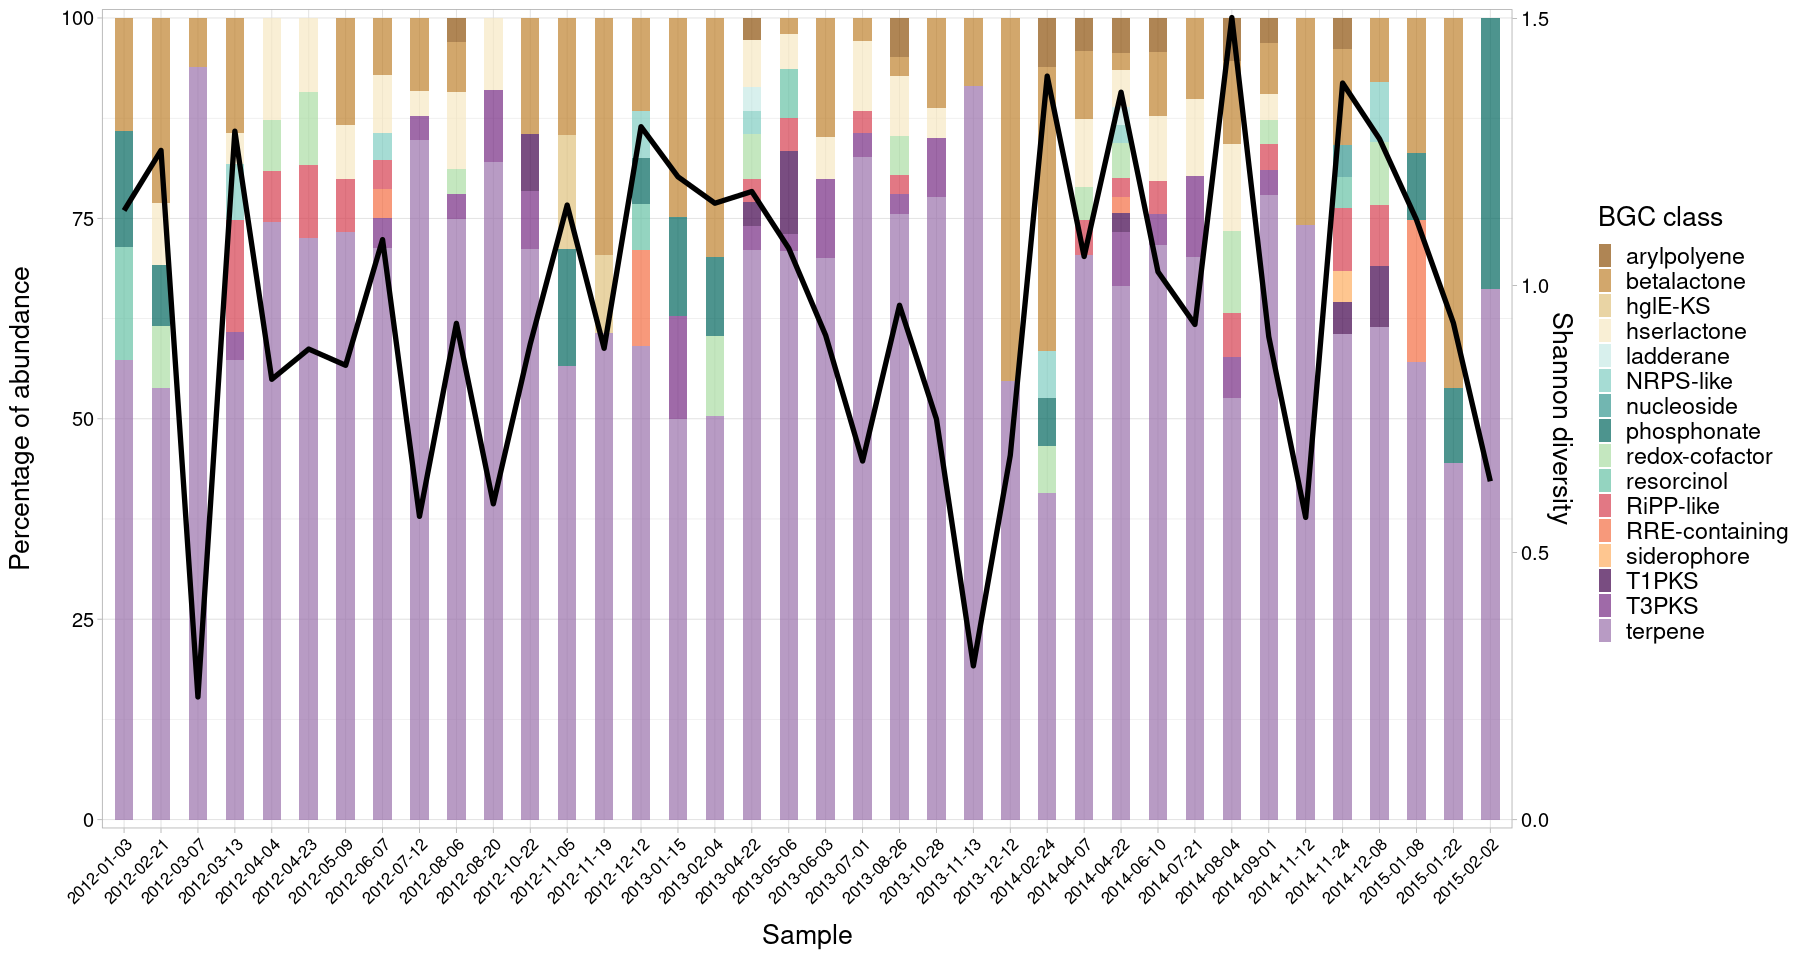

In [184]:
bgc_colors <- c('#8c510a','#bf812d','#dfc27d','#f6e8c3',
                '#c7eae5','#80cdc1','#35978f','#01665e',
                '#abdda4','#66c2a5', '#d53e4f','#f46d43',
                '#fdae61','#40004b','#762a83', '#9970ab')

season_colors <- c("#154360", "#3c7810", "#c93f1b","#98482b")

bgc_class_names <- unique(BGC_TBL_coll$bgc_class)
names(bgc_colors) <- bgc_class_names[order(bgc_class_names)]

text_size <- 12
BGC_TBL_coll_div <- BGC_TBL_coll %>%
                    group_by(collection_date) %>%
                    summarize(shannon = diversity(abund_rel))

barplot <- ggplot(BGC_TBL_coll, aes(x = collection_date, y = abund_rel, fill = bgc_class)) + 
           geom_bar(stat = "identity", width = 0.5, alpha = 0.7) +
           xlab("Sample") +
           ylab("Percentage of abundance") +
           scale_fill_manual(name="BGC class",
                             values = bgc_colors) +
           scale_y_continuous(expand=c(0,0.1), limits = c(-1,101), 
                              sec.axis = sec_axis(~.*(max(BGC_TBL_coll_div$shannon)/101), name = "Shannon diversity")) +
           theme_light() +
           theme( 
                 axis.text.x = element_text(size = text_size -2, angle = 45, 
                                            hjust = 1, color = "black"),
                 axis.text.y = element_text(size = text_size, color = "black"),
                 axis.title.x = element_text(size = text_size + 4, color = "black",
                                             margin = margin(10,0,0,0)),
                 axis.title.y = element_text(size = text_size + 4, color = "black",
                                             margin = margin(0,15,0,0)),
                 legend.text = element_text(size = text_size +2, color = "black"),
                 legend.title = element_text(size = text_size +4 , color = "black"),
                 legend.position = "right",
                 legend.margin = ggplot2::margin(0,0,-5,0),
                 strip.background = element_blank(),
                 strip.text = element_text(color = "black", size = text_size)) +
                 guides(fill = guide_legend(keywidth = 0.6, keyheight = 0.6)) +
          geom_line(data = BGC_TBL_coll_div, aes(y = shannon*(99/1.5), fill = NULL, group = 1),
                     linewidth = 1.5) 

options(repr.plot.width=15, repr.plot.height=8)
barplot

As expected for surface marine environment, we observed a high abundance of terpenes. Similar results have been observed by [Paoli 2022](https://www.nature.com/articles/s41586-022-04862-3) and [Pereira 2020](https://www.biorxiv.org/content/10.1101/2021.01.20.427441v1). This finding could be explained by a higher abundance of carotenoid pigments involved in light harvesting and oxidative stress protection processes.
Interestingly, winter samples tend to have a greater diversity.

Let's see how a two-way clustering heatmap looks like.  
First, we generate the clusters.

In [191]:
BGC_TBL_coll_wide <- BGC_TBL_coll %>%
                     select(-abund_rel, -Season) %>%
                     pivot_wider(names_from = bgc_class, 
                                 values_from = abund, 
                                 values_fill = 0) %>%
                     column_to_rownames("collection_date")

BGC_TBL_norm <- decostand(BGC_TBL_coll_wide, method = "hellinger")
sample_clust <- hclust(vegdist(BGC_TBL_norm, method = "euclidean"), method="ward.D")
bgc_clust <- hclust(vegdist(t(BGC_TBL_norm), method = "euclidean"), method="ward.D")

sample_clust_dendro <- sample_clust %>%
                       as.dendrogram
bgc_clust_dendro <- bgc_clust %>%
                    as.dendrogram 

sample_clust_data <- dendro_data(sample_clust_dendro)
bgc_clust_data <- dendro_data(bgc_clust_dendro)


And the dendro plots.

In [192]:
sample_clust_metadata <- data.frame(collection_date = label(sample_clust_data)$label %>% 
                                    as.character,
                                    x = label(sample_clust_data)$x,
                                    y = label(sample_clust_data)$y) %>%
                         mutate(Season = get_season_north(collection_date))

season_colors <- c("#154360", "#3c7810", "#c93f1b","#98482b")

sample_clust_plot <- ggplot(segment(sample_clust_data)) +
                     coord_flip() +
                     geom_segment(aes(x=x, y=y, xend=xend, yend=yend), linewidth = 0.2) +
                     geom_point(data = sample_clust_metadata, 
                                aes(x = x , y = y, colour = Season),
                                    shape = 15, size = 4, alpha = 0.8) +
                     scale_colour_manual(values=season_colors) +
                     theme_void() +
                     theme(plot.margin = unit(c(-1,1,6.5,0.2), "lines"))

bgc_clust_plot <- ggplot(segment(bgc_clust_data)) +
                  geom_segment(aes(x=x, y=y, xend=xend, yend=yend), linewidth = 0.2) +
                  theme_void() +
                  theme(plot.margin = unit(c(1,14.5,-0.5,7.5), "lines"))

Now the heatmap.

In [193]:
BGC_TBL_norm_long <- BGC_TBL_norm %>%
                     as.data.frame %>%
                     rownames_to_column("collection_date") %>%
                     pivot_longer(names_to = "bgc_class", 
                                  values_to = "abund", 
                                  cols = 2:(dim(BGC_TBL_norm)[2]+1))
                     
BGC_TBL_norm_long$collection_date <- factor(BGC_TBL_norm_long$collection_date, 
                                            levels = sample_clust$labels[sample_clust$order])
BGC_TBL_norm_long$bgc_class <- factor(BGC_TBL_norm_long$bgc_class, 
                                      levels = bgc_clust$labels[bgc_clust$order])
heatmap <- ggplot(BGC_TBL_norm_long, aes(x = collection_date, y = bgc_class, fill = abund)) + 
           geom_tile() +
           xlab("Collection date") +
           ylab("BGC class") +
           theme_light() +
           theme( 
                 axis.text.x = element_text(size = text_size, angle = 45, hjust = 1, color = "black"),
                 axis.text.y = element_text(size = text_size, color = "black"),
                 axis.title.x = element_text(size = text_size + 4, color = "black",
                                             margin = margin(10,0,0,0)),
                 axis.title.y = element_text(size = text_size + 4, color = "black",
                                             margin = margin(0,15,0,0)),
                 legend.text = element_text(size = text_size +2, color = "black"),
                 legend.title = element_text(size = text_size +4 , color = "black"),
                 legend.position = c(1.3,0.95),
                 legend.margin = ggplot2::margin(0,0,-5,0),
                 strip.background = element_blank(),
                 strip.text = element_text(color = "black", size = text_size),
                 plot.margin = unit(c(0.2,0,1,1), "lines")) +
            guides(fill = guide_legend(keywidth = 0.6, keyheight = 0.6)) +
            scale_fill_gradient(low="white", high="#01665e", name = "% of abundance") +
            coord_flip()

Merge all plots

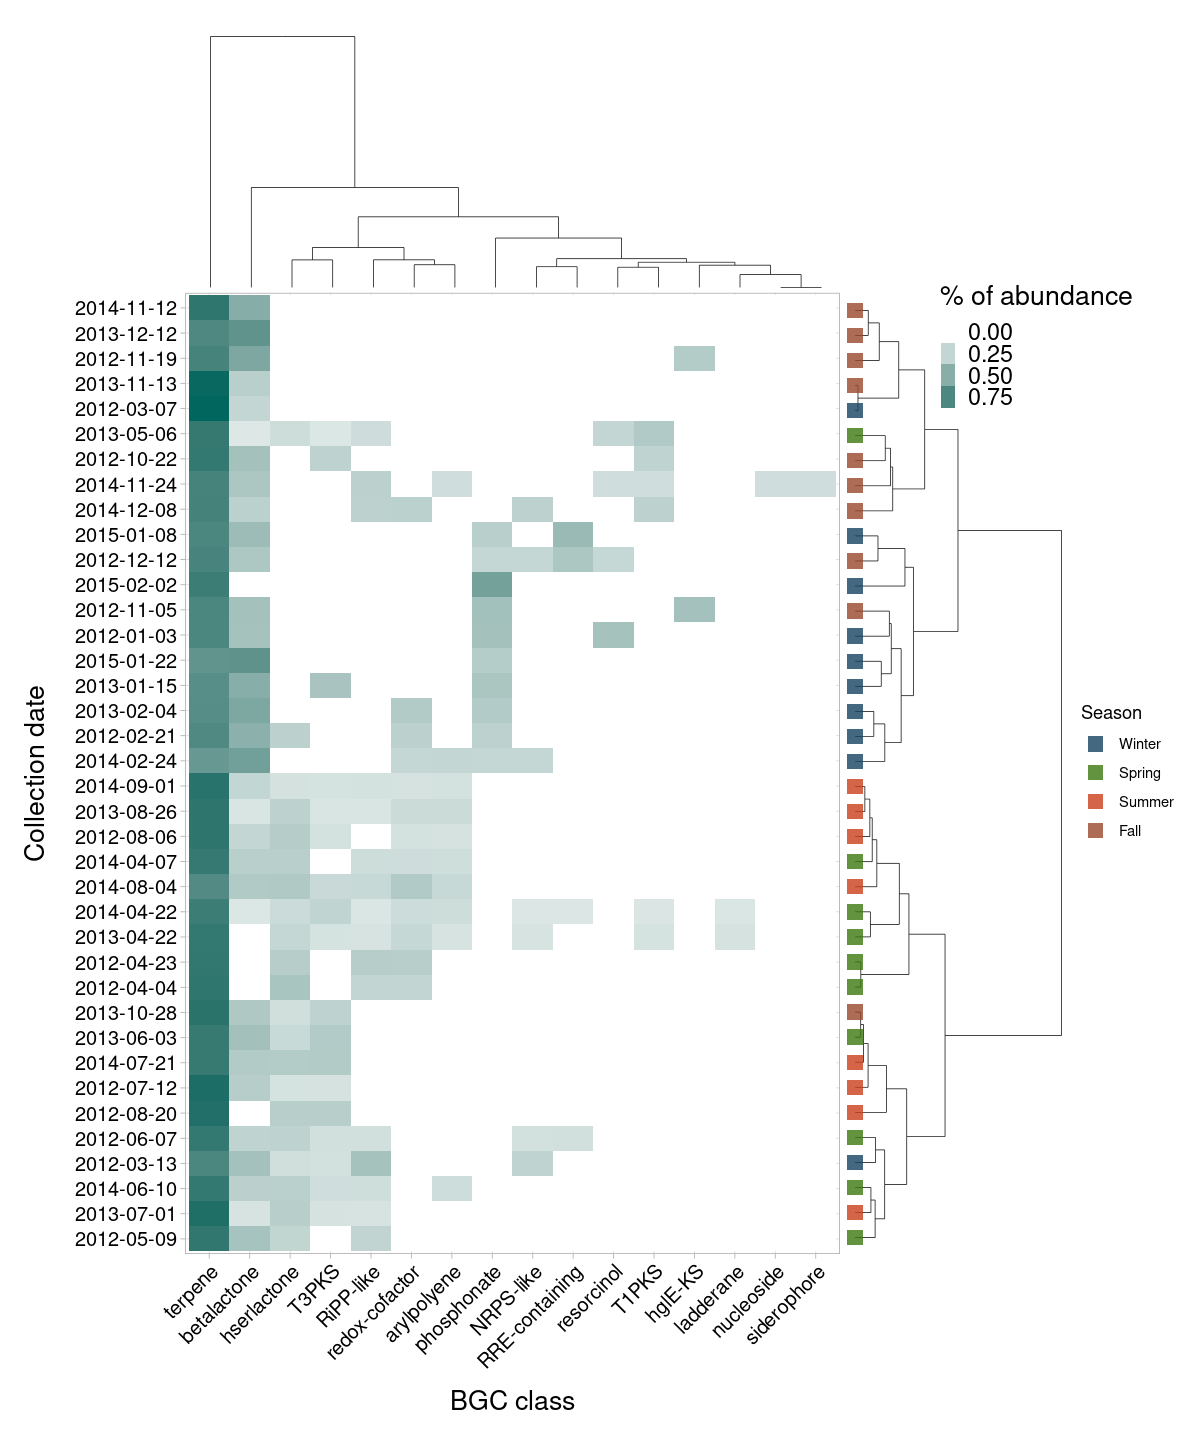

In [194]:
heatmap_1 <- ggarrange(heatmap, sample_clust_plot,
                       nrow = 1, ncol = 2, 
                       widths = c(0.7, 0.3))

heatmap_1and2 <- ggarrange(bgc_clust_plot, heatmap_1,    
                           nrow = 2, ncol = 1,  
                           heights = c(0.2, 0.8))

options(repr.plot.width=10, repr.plot.height=12)
heatmap_1and2

Notably, the two main clusters separate the semesters winter and fall from summer and spring.

<a id='section2'></a>
**1.  Explore the BGC's taxonomic composition**

Here we are going to analyze the distribution of the number of BGC sequences per class and phyla.  
First we need to match the BGC abundance and TAXA tables and get the phyum annotations.

In [195]:
bgc2taxa <- left_join(x = BGC_TBL, y = TAXA_TBL, by = c("seq_id","sample")) %>%
            mutate(tax_path2 = if_else(grepl(pattern = ".*;p_[^;]+;.*", tax_path, perl = T), tax_path, "p_Other;")) %>%
            mutate(phylum = sub(".*p_([^;]+);.*", "\\1", tax_path2)) %>%
            select(-tax_path, -tax_level)

head(bgc2taxa, n = 5)

sample,seq_id,edge,bgc_class,abund,tax_path2,phylum
<chr>,<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>
ERR2604071,ERR2604071__k119_144067,TRUE,phosphonate,1.041835,-_cellular organisms;d_Bacteria;-_Terrabacteria group;p_Actinomycetota;c_Actinomycetes;o_Kitasatosporales;f_Streptomycetaceae;g_Streptomyces,Actinomycetota
ERR2604071,ERR2604071__k119_154594,TRUE,betalactone,1.014010,p_Other;,Other
ERR2604071,ERR2604071__k119_29665,TRUE,resorcinol,1.011193,-_cellular organisms;d_Bacteria;p_Pseudomonadota;c_Alphaproteobacteria;o_Hyphomicrobiales;f_Phyllobacteriaceae;g_Mesorhizobium;s_Mesorhizobium japonicum;-_Mesorhizobium japonicum MAFF 303099,Pseudomonadota
ERR2604071,ERR2604071__k119_29813,TRUE,terpene,1.021466,p_Other;,Other
ERR2604071,ERR2604071__k119_50764,TRUE,terpene,1.034165,p_Other;,Other


Now that we all organized in a single table, we can create the plots.

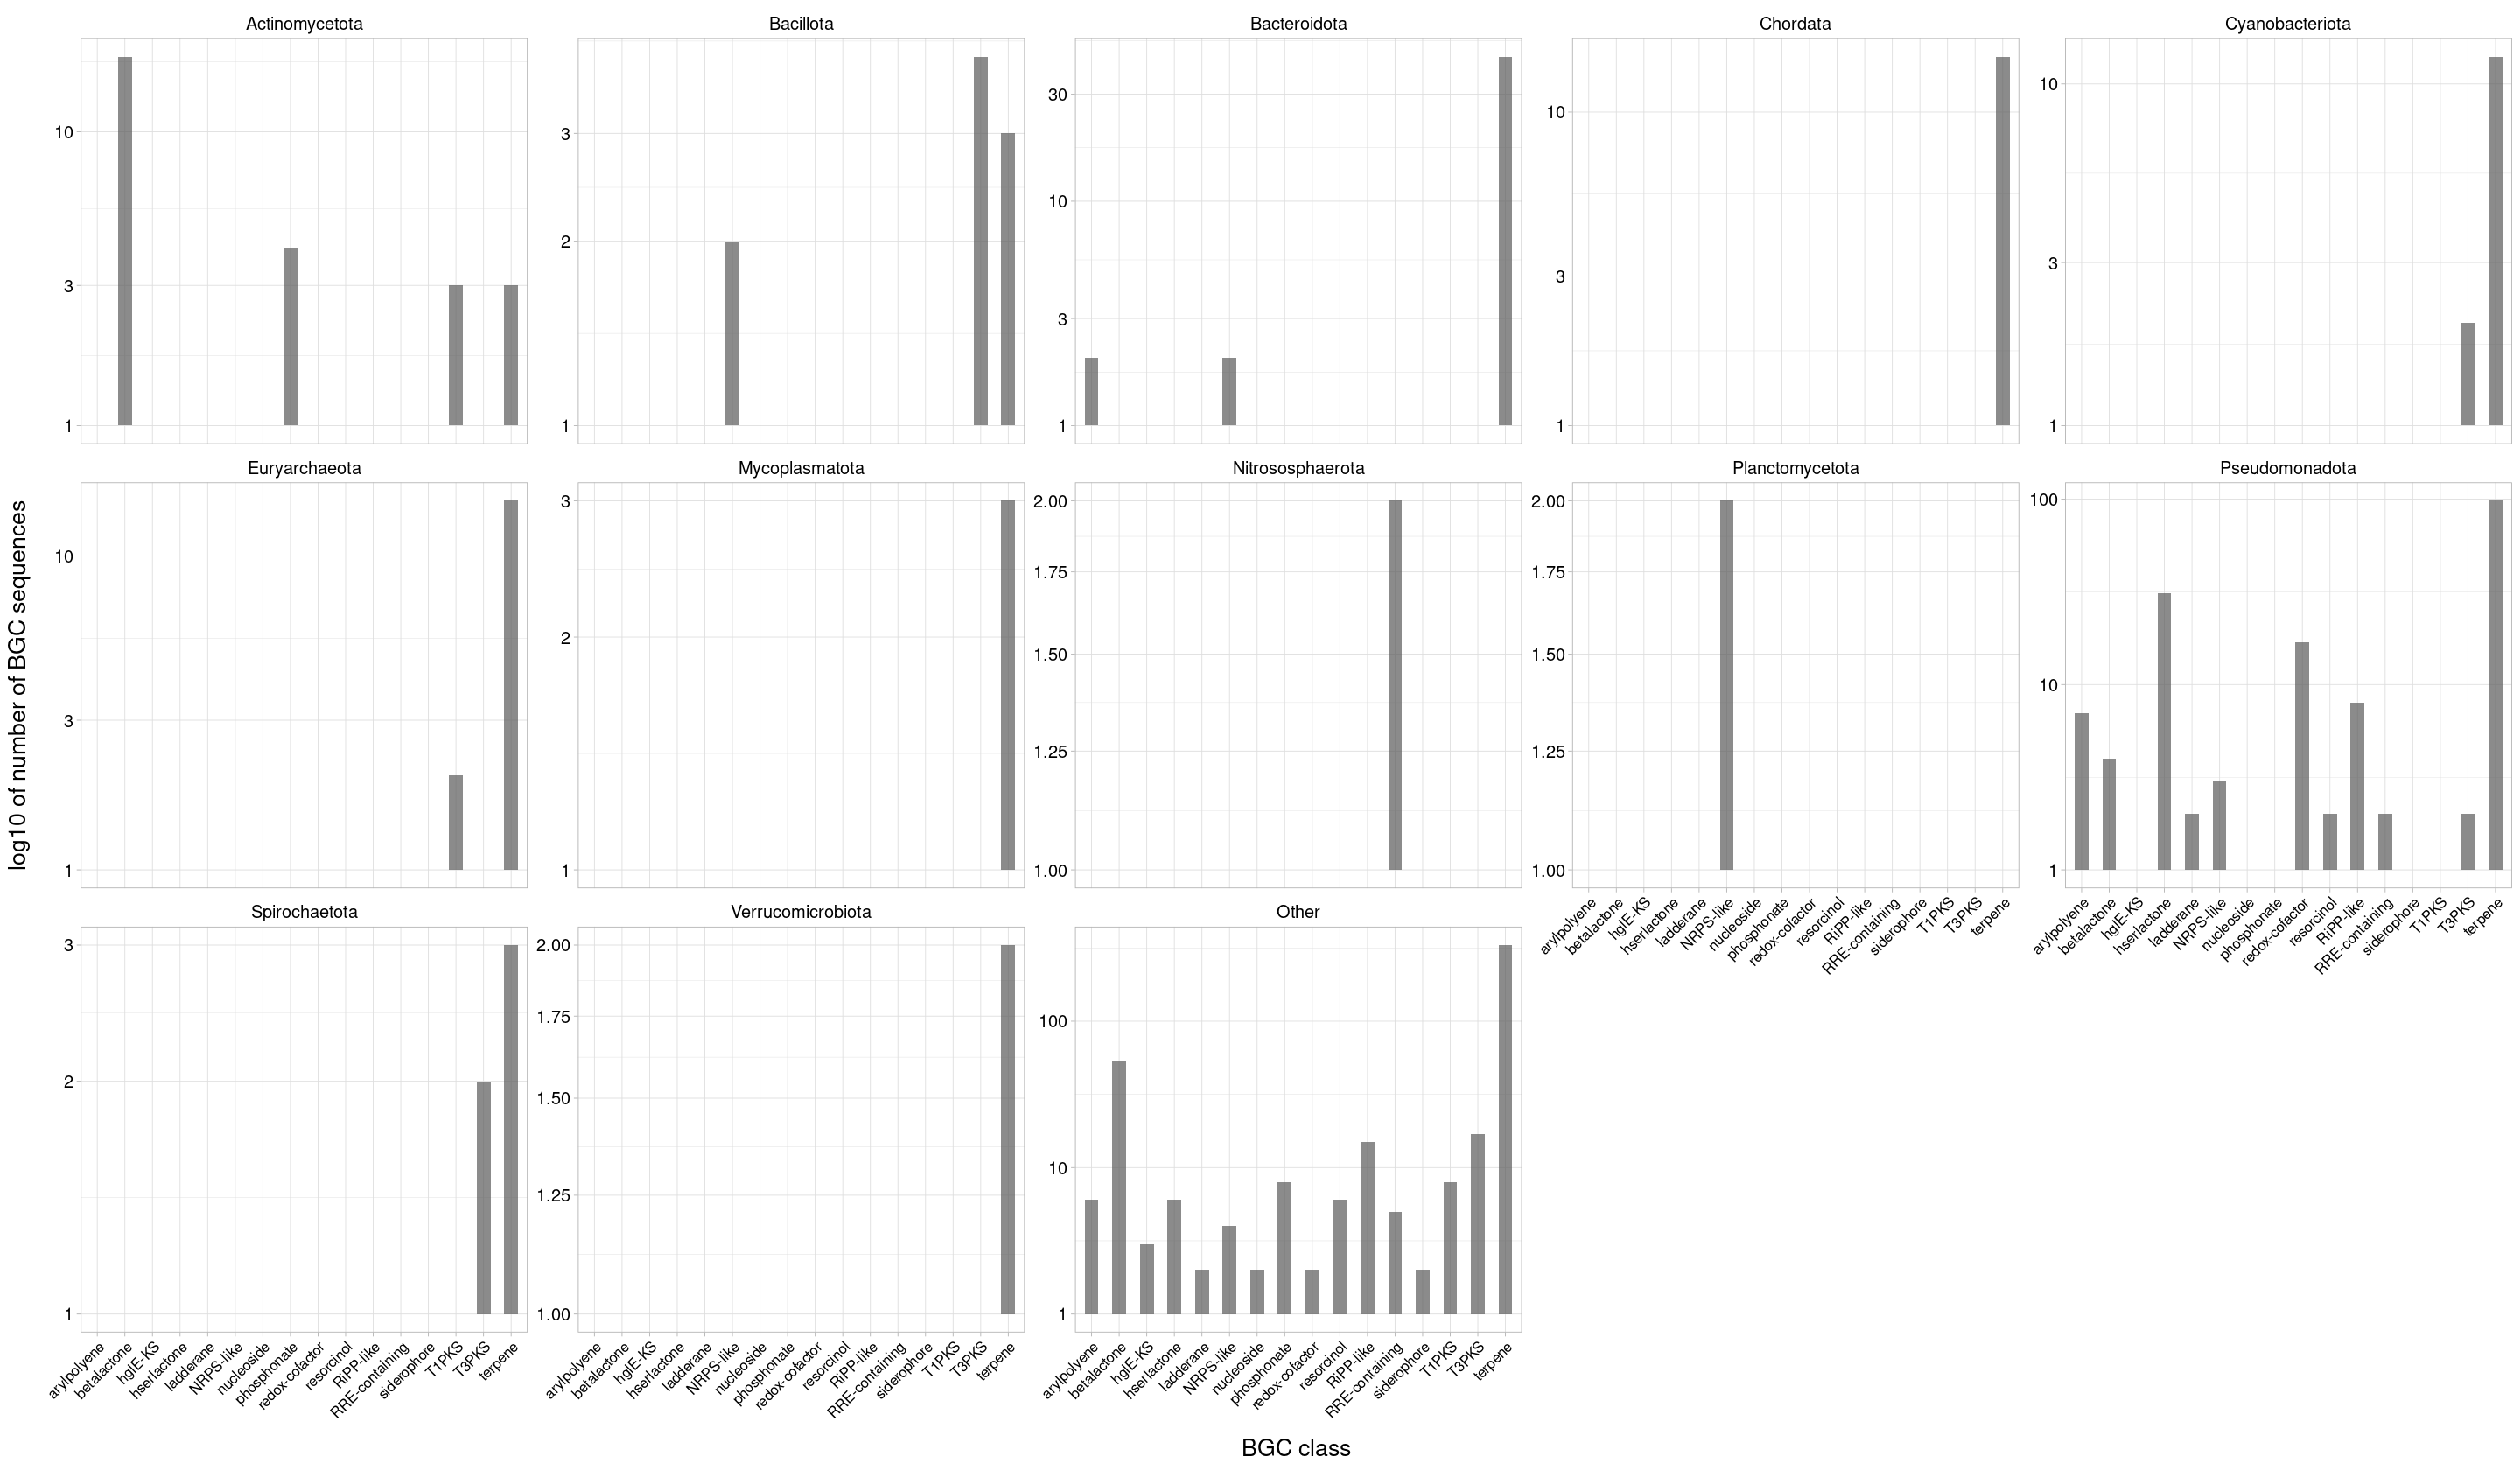

In [196]:
phyla_names <- unique(bgc2taxa$phylum)
i <- phyla_names!="Other"
phyla_names <- c(phyla_names[i][order(phyla_names[i])], "Other")

bgc2taxa_counts <- bgc2taxa %>%
                   group_by(phylum, bgc_class) %>%
                   summarize(bgc_seqs_n = unique(seq_id) %>% length) %>%
                   ungroup()

bgc2taxa_counts$phylum <- factor(bgc2taxa_counts$phylum, levels = phyla_names)

phyla_barplot <- ggplot(data = bgc2taxa_counts, aes(x = bgc_class, y = bgc_seqs_n +1)) + 
                 facet_wrap(~phylum, scales = "free_y", ncol = 5) +
                 geom_bar(stat = "identity", width = 0.5, alpha = 0.7) +
                 xlab("BGC class") +
                 ylab("log10 of number of BGC sequences") +
                 scale_y_log10() +
                 theme_light() +
                 theme( 
                       axis.text.x = element_text(size = text_size -2, angle = 45, hjust = 1, color = "black"),
                       axis.text.y = element_text(size = text_size, color = "black"),
                       axis.title.x = element_text(size = text_size + 4, color = "black",
                                                   margin = margin(10,0,0,0)),
                       axis.title.y = element_text(size = text_size + 4, color = "black",
                                                   margin = margin(0,15,0,0)),
                       legend.text = element_text(size = text_size +2, color = "black"),
                       legend.title = element_text(size = text_size +4 , color = "black"),
                       legend.position = "right",
                       legend.margin = ggplot2::margin(0,0,-5,0),
                       strip.background = element_blank(),
                        strip.text = element_text(color = "black", size = text_size)) +
                 guides(fill = guide_legend(keywidth = 0.6, keyheight = 0.6)) 

options(repr.plot.width=24, repr.plot.height=14)
phyla_barplot


Now let's analyze the taxomoic composition of the comlete BGC sequences. 

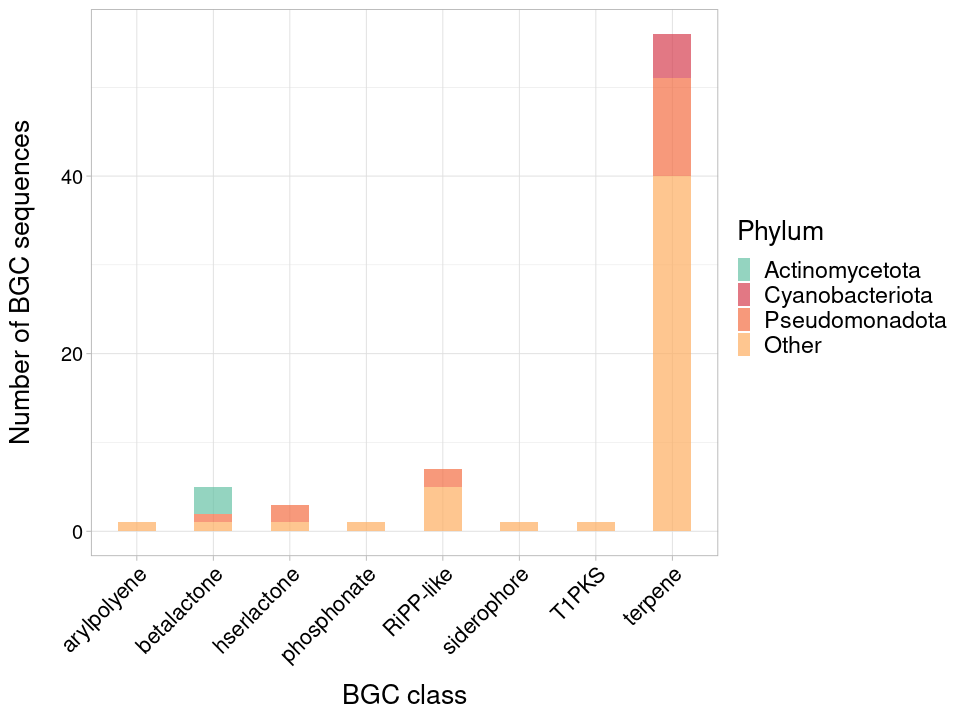

In [197]:
phyla_colors <-  as.character(bgc_colors[10:16])

bgc2taxa_counts_complete <- bgc2taxa %>%
                            filter(edge == F) %>%
                            group_by(bgc_class, phylum) %>%
                            summarize(seqs_n_tax = n()) %>%
                            group_by(bgc_class) %>%
                            mutate(seqs_n_tax_rel = 100*seqs_n_tax/sum(seqs_n_tax))

phyla_names <- unique(bgc2taxa_counts_complete$phylum)
i <- phyla_names!="Other"
phyla_names <- c(phyla_names[i][order(phyla_names[i])], "Other")
bgc2taxa_counts_complete$phylum <- factor(bgc2taxa_counts_complete$phylum, levels = phyla_names)

taxa2bgc_barplot <- ggplot(bgc2taxa_counts_complete, aes(x = bgc_class, y = seqs_n_tax, fill = phylum)) + 
                    geom_bar(stat = "identity", width = 0.5, alpha = 0.7) +
                    xlab("BGC class") +
                    ylab("Number of BGC sequences") +
                    scale_fill_manual(name="Phylum",
                                      values = phyla_colors) +
                  #  scale_y_continuous(expand=c(0,0.1), limits = c(-1,101)) +
                    theme_light() +
                    theme( 
                          axis.text.x = element_text(size = text_size +1, angle = 45, hjust = 1, color = "black"),
                          axis.text.y = element_text(size = text_size, color = "black"),
                          axis.title.x = element_text(size = text_size + 4, color = "black",
                                                      margin = margin(10,0,0,0)),
                          axis.title.y = element_text(size = text_size + 4, color = "black",
                                                      margin = margin(0,15,0,0)),
                          legend.text = element_text(size = text_size +2, color = "black"),
                          legend.title = element_text(size = text_size +4 , color = "black"),
                          legend.position = "right",
                          legend.margin = ggplot2::margin(0,0,-5,0),
                          strip.background = element_blank(),
                          strip.text = element_text(color = "black", size = text_size)) +
                    guides(fill = guide_legend(keywidth = 0.6, keyheight = 0.6)) 

options(repr.plot.width=8, repr.plot.height=6)
taxa2bgc_barplot

<a id='section3'></a>
**3. Explore the BGC diversity**

In this analysis we are going to create rarefaction curves based on the Gene Cluster Families (GCFs) obtained with BiG-SLICE.  
For this, we will follow the same approach that is traditionally applied when working with Operation Taxonomic Units (OTUs).

Let's first load the clustering data.

In [198]:
BGC_CLUST <- read_tsv("outputs/bigscape_clust/network_files/2023-09-14_21-29-19_hybrids_glocal/all_clustering_c1.00.tsv", 
                     col_names = T, show_col_type = F)
head(BGC_CLUST, n = 5)

bgc,sample,seq_id,cluster_id
<chr>,<chr>,<chr>,<dbl>
NRPS,ERR2604075,ERR2604075__k119_105538.region001,1926
NRPS,ERR2604075,ERR2604075__k119_126519.region001,1926
NRPS,ERR2604079,ERR2604079__k119_217212.region001,1926
NRPS,ERR2604090,ERR2604090__k119_80411.region001,2377
NRPS,ERR2604100,ERR2604100__k119_37866.region001,2377


From this table, we are going to construct a `sample x GCF abundance` matrix.  
Thus, we have to map the BGCs' abundance data from our `BGC_TBL`.

In [223]:
bcg_clust2abund <- BGC_CLUST %>%
                   mutate(seq_id = sub(x = seq_id, pattern = ".region.*", replacement = "")) %>%
                   left_join(x = .,
                             y = BGC_TBL %>% select(-sample),
                             by = "seq_id") %>%
                   select(bgc, sample, cluster_id, abund) %>%
                   group_by(bgc, sample, cluster_id) %>%
                   summarize(abund = sum(abund)) %>%
                   left_join(x =., 
                             y = METADATA_TBL %>% select(run_accession, collection_date),
                             by = c("sample" = "run_accession")) %>%
                    ungroup %>%
                    select(-sample) %>%
                    mutate(sample = as.character(collection_date))
               

Next, we have to rarefy the data, where we will be using our custom R function: [custom_rarefy](https://github.com/pereiramemo/bioprospecting/blob/main/aux_scripts/custom_rarefy.R)

In [230]:
bgc_names <- unique(bcg_clust2abund$bgc)
rare_plots_list <- list()

for (i in bgc_names) {
  
  rare_data <- custom_rarefy(TBL = bcg_clust2abund, bgc_name = i, n_cores = 20)
  
  if (is.null(rare_data)) { 
    
    next()
    
  }
  
  rare_data$rare$Season <- get_season_north(rare_data$rare$sample)
  rare_plots_list[[i]] <- ggplot(rare_data$rare, 
                                 aes(x = iteration, 
                                     y = richness, 
                                     group = sample, 
                                     color = Season)) +
                          scale_color_manual("Season", values = season_colors) +
                          geom_line(linewidth = 1.2, alpha = 0.7) +
                          ylab("Richness") +
                          xlab("Sample size") +
                          scale_x_continuous(labels = scales::scientific, 
                                             limits = c(0,  max(rare_data$rare$iteration) + 3)) +
                          scale_y_continuous(labels = scales::scientific) +
                          theme_bw() +
                          theme( 
                                axis.text.x = element_text(size = text_size +1, color = "black"),
                                axis.text.y = element_text(size = text_size, color = "black"),
                                axis.title.x = element_text(size = text_size + 4, color = "black",
                                                            margin = margin(10,0,0,0)),
                                axis.title.y = element_text(size = text_size + 4, color = "black",
                                                            margin = margin(0,15,0,0)),
                                legend.text = element_text(size = text_size +2, color = "black"),
                                legend.title = element_text(size = text_size +4 , color = "black"),
                                legend.position = "right",
                                legend.margin = ggplot2::margin(0,0,-5,0),
                                strip.background = element_blank(),
                                strip.text = element_text(color = "black", size = text_size)) +
                           guides(fill = guide_legend(keywidth = 0.6, keyheight = 0.6)) +
                          annotate("text", 
                                   label = rare_data$coords$sample, 
                                   x = rare_data$coords$max_interation, 
                                   y = rare_data$coords$max_richness+ 1,
                                   size = 4, check_overlap = T) 
}


For now, the only BGC class for which we can create this plot are the Terpenes, for all the others we don't have enough data. 

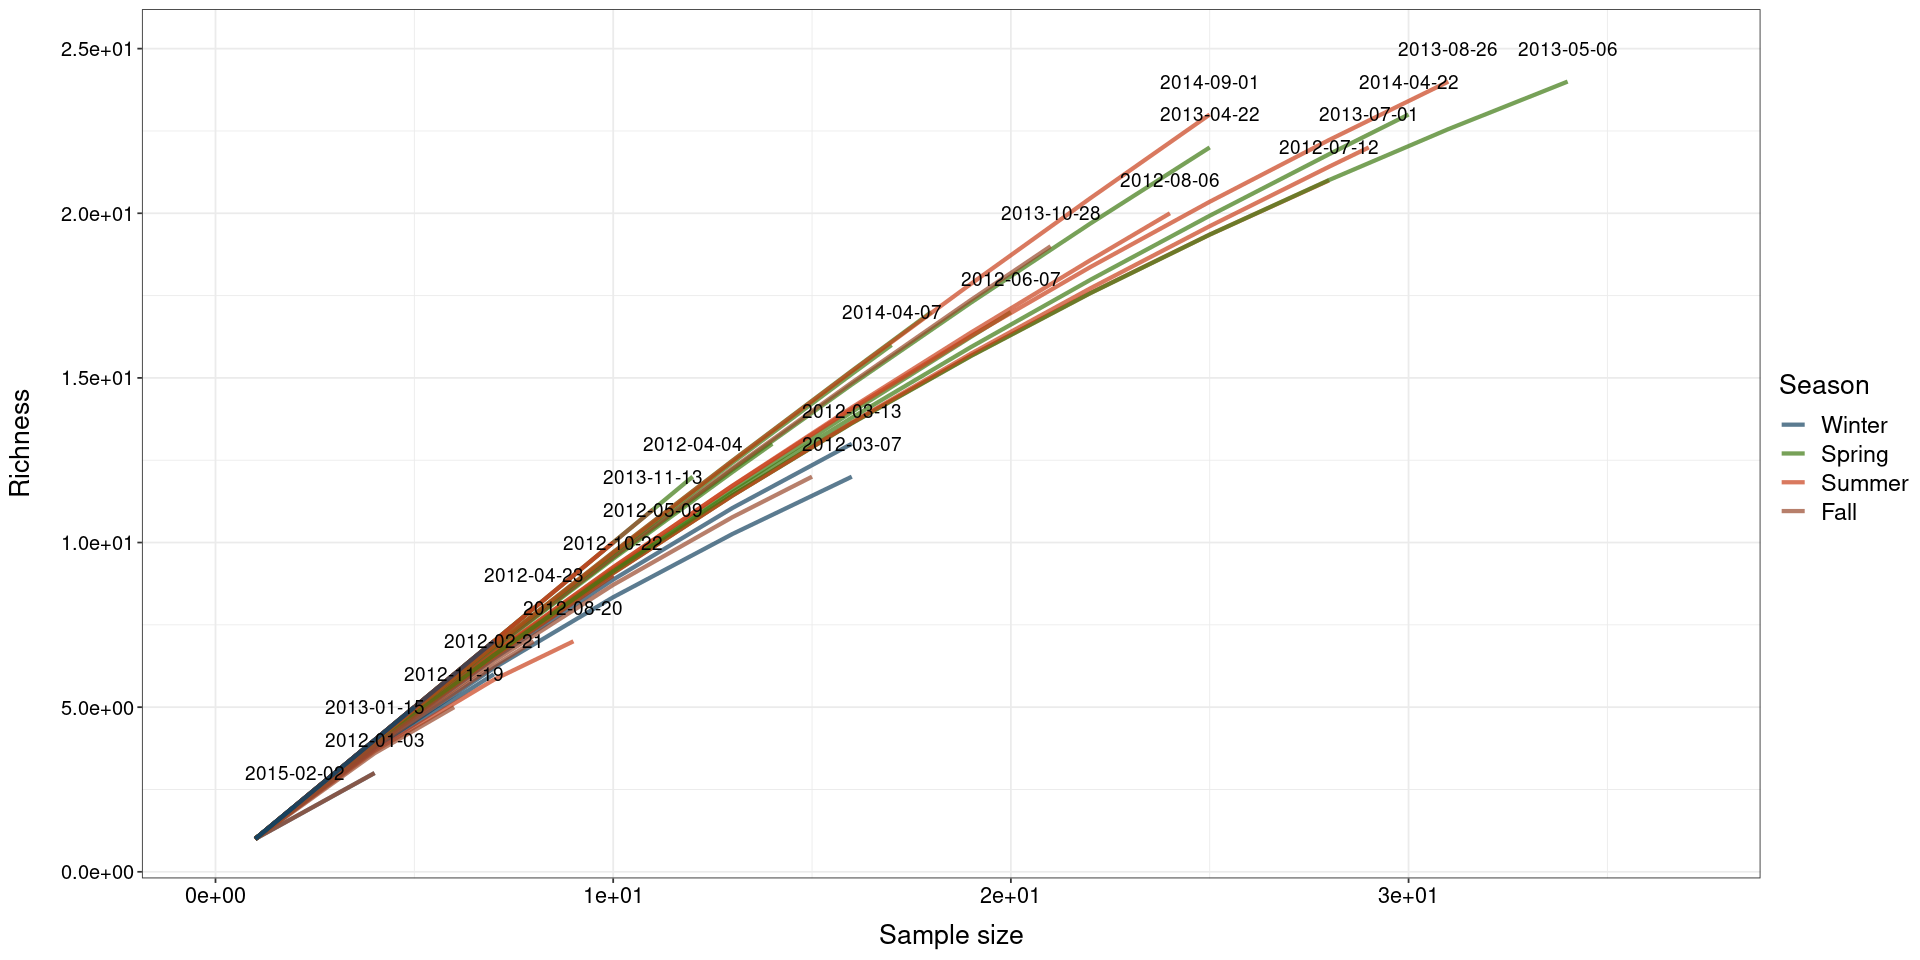

In [233]:
options(repr.plot.width=16, repr.plot.height=8)
rare_plots_list$Terpene

This figure shows that the samples from Summer and Spring have a much higher abundance of terpenes and a greater diversity.  
Worth noting that, none of the curves reach a plateau, that is, a greater sampling effort is needed to capture the diversity of terpenes in these environments.  

<a id='section4'></a>
**3. Assess the BGC novelty**

Lastly, let's assess the novely of all BGC sequences, and which are the most similar reference BGCs from [MIBiG DB](https://mibig.secondarymetabolites.org/).  
For this, we are going to use the output from with [BiG-SCAPE](https://github.com/medema-group/BiG-SCAPE), which was used to cluster the BGC sequences identified in our metagenomic samples together with samples from MIBiG. 
Let's load the table with all the distances between reference and query BGC sequences.

In [392]:
BGC_DIST <- read_tsv("outputs/bigscape_clust/network_files/2023-09-14_21-29-19_hybrids_glocal/all_c1.00.network", 
                     col_names = T, show_col_type = F)

head(BGC_DIST)

bgc,Clustername 1,Clustername 2,Raw distance,Squared similarity,Jaccard index,DSS index,Adjacency index,raw DSS non-anchor,raw DSS anchor,Non-anchor domains,Anchor domains,Combined group,Shared group
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
NRPS,BGC0000437.1,BGC0000950.1,0.9678986,0.001030498,0.2187500,0.03210136,0.11363637,0.9603376,0.9704291,83,62,nrps - nrps,nrps
NRPS,BGC0000346.1,BGC0000423.1,0.8019639,0.039218307,0.2068966,0.19803613,0.20000000,0.8160537,0.7954609,24,13,nrps - nrps.t1pks,NA
NRPS,BGC0001371.1,BGC0001754.1,0.8571557,0.020404503,0.2500000,0.14284433,0.15151516,0.9154035,0.8303310,35,19,nrps - nrps.t1pks,NA
NRPS,BGC0000314.1,BGC0001417.1,0.7914183,0.043506343,0.2592593,0.20858175,0.17647059,0.8166050,0.7843808,19,17,nrps - nrps.t1pks,NA
NRPS,BGC0000385.1,BGC0000397.1,0.8626962,0.018852349,0.0617284,0.13730386,0.05050505,0.9350006,0.7958145,111,30,nrps - transatpks.nrps.lantipeptide,NA
NRPS,BGC0001102.1,BGC0001449.1,0.8976737,0.010470671,0.3548387,0.10232630,0.15909091,0.9296436,0.8752948,28,10,nrps.t1pks - transatpks.nrps.t1pks,NA


And now extract our metagenome BGC sequences.

In [264]:
BGC_DIST_redu <- BGC_DIST %>% 
                 filter( grepl(x = `Clustername 1`, pattern = "BGC", perl = T) & grepl(x = `Clustername 2`, pattern = "ERR", perl = T) ) 
head(BGC_DIST_redu)

bgc,Clustername 1,Clustername 2,Raw distance,Squared similarity,Jaccard index,DSS index,Adjacency index,raw DSS non-anchor,raw DSS anchor,Non-anchor domains,Anchor domains,Combined group,Shared group
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
NRPS,BGC0001108.1,ERR2604075__k119_105538.region001,0.9936134,4.078931e-05,0.13043478,0.006386651,0.02941176,0.9923850,0.9942275,48,24,NRPS-like - transatpks.nrps,NA
NRPS,BGC0000463.1,ERR2604098__k119_211631.region001,0.9931585,4.680674e-05,0.16666667,0.006841545,0.07142857,0.9929957,0.9932076,29,24,NRPS-like - nrps,NA
NRPS,BGC0001631.1,ERR2604098__k119_211631.region001,0.9804423,3.825033e-04,0.13333334,0.019557692,0.00000000,0.9834559,0.9793750,17,12,NRPS-like - nrps.t1pks,NA
NRPS,BGC0000456.1,ERR2604075__k119_126519.region001,0.9820668,3.215997e-04,0.21428572,0.017933201,0.05555556,0.9433812,0.9871870,9,17,NRPS-like - nrps,NA
NRPS,BGC0001751.1,ERR2604100__k119_37866.region001,0.9914890,7.243774e-05,0.05000000,0.008511037,0.00000000,0.9963427,0.9887820,58,26,NRPS-like - t2pks.transatpks.nrps,NA
NRPS,BGC0001582.1,ERR2604086__k119_291904.region001,0.9923096,5.914262e-05,0.07142857,0.007690424,0.02941176,0.9937177,0.9918285,41,30,NRPS-like - nrps.lantipeptide,NA


Let's select the BGC from MIBiG that have the shortest distance to our metagenomic BGCs.

In [375]:
BGC_DIST_redu_min_dist <- BGC_DIST_redu %>%
                          mutate(`Clustername 2` = sub(x = `Clustername 2`, pattern = ".region.*", replacement = "")) %>%
                          left_join(x = ., 
                                    y = bgc2taxa, 
                                    by = c("Clustername 2" = "seq_id")) %>%
                          group_by(bgc, `Clustername 2`) %>%
                          mutate(min_dist = min(`Raw distance`)) %>%
                          filter(`Raw distance` <= min_dist)
                          

head(BGC_DIST_redu_min_dist, n = 5)

bgc,Clustername 1,Clustername 2,Raw distance,Squared similarity,Jaccard index,DSS index,Adjacency index,raw DSS non-anchor,raw DSS anchor,⋯,Anchor domains,Combined group,Shared group,sample,edge,bgc_class,abund,tax_path2,phylum,min_dist
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<chr>,<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
NRPS,BGC0001263.1,ERR2604090__k119_80411,0.8967490,0.010660783,0.1666667,0.10325107,0.09090909,0.9140625,0.8924205,⋯,2,NRPS-like - nrps,NA,ERR2604090,TRUE,NRPS-like,1.059217,-_cellular organisms;d_Bacteria;p_Pseudomonadota;c_Gammaproteobacteria,Pseudomonadota,0.8967490
NRPS,BGC0001263.1,ERR2604086__k119_291904,0.9098077,0.008134652,0.1818182,0.09019231,0.09090909,0.9384615,0.9026442,⋯,2,NRPS-like - nrps,NA,ERR2604086,TRUE,NRPS-like,1.029577,-_cellular organisms;d_Bacteria;-_PVC group;p_Planctomycetota;c_Planctomycetia;o_Pirellulales;f_Pirellulaceae;g_Rhodopirellula;s_Rhodopirellula baltica;-_Rhodopirellula baltica SH 1,Planctomycetota,0.9098077
NRPS,BGC0001263.1,ERR2604098__k119_211631,0.9203997,0.006336216,0.2857143,0.07960035,0.16666667,0.9015151,0.9251208,⋯,2,NRPS-like - nrps,NA,ERR2604098,TRUE,NRPS-like,1.044605,-_cellular organisms;d_Bacteria;-_Terrabacteria group;p_Bacillota;c_Bacilli;o_Bacillales;f_Bacillaceae;g_Bacillus;-_Bacillus subtilis group;s_Bacillus subtilis,Bacillota,0.9203997
NRPS,BGC0001263.1,ERR2604100__k119_37866,0.8977270,0.010459782,0.1176471,0.10227308,0.05882353,0.9140625,0.8936430,⋯,2,NRPS-like - nrps,NA,ERR2604100,TRUE,NRPS-like,1.056734,-_cellular organisms;d_Bacteria;p_Pseudomonadota;c_Gammaproteobacteria,Pseudomonadota,0.8977270
NRPS,BGC0001263.1,ERR2604107__k119_273037,0.9071096,0.008628635,0.1666667,0.09289044,0.08333334,0.9393939,0.8990384,⋯,2,NRPS-like - nrps,NA,ERR2604107,TRUE,NRPS-like,1.007333,p_Other;,Other,0.9071096


Let's see this in a boxplot.

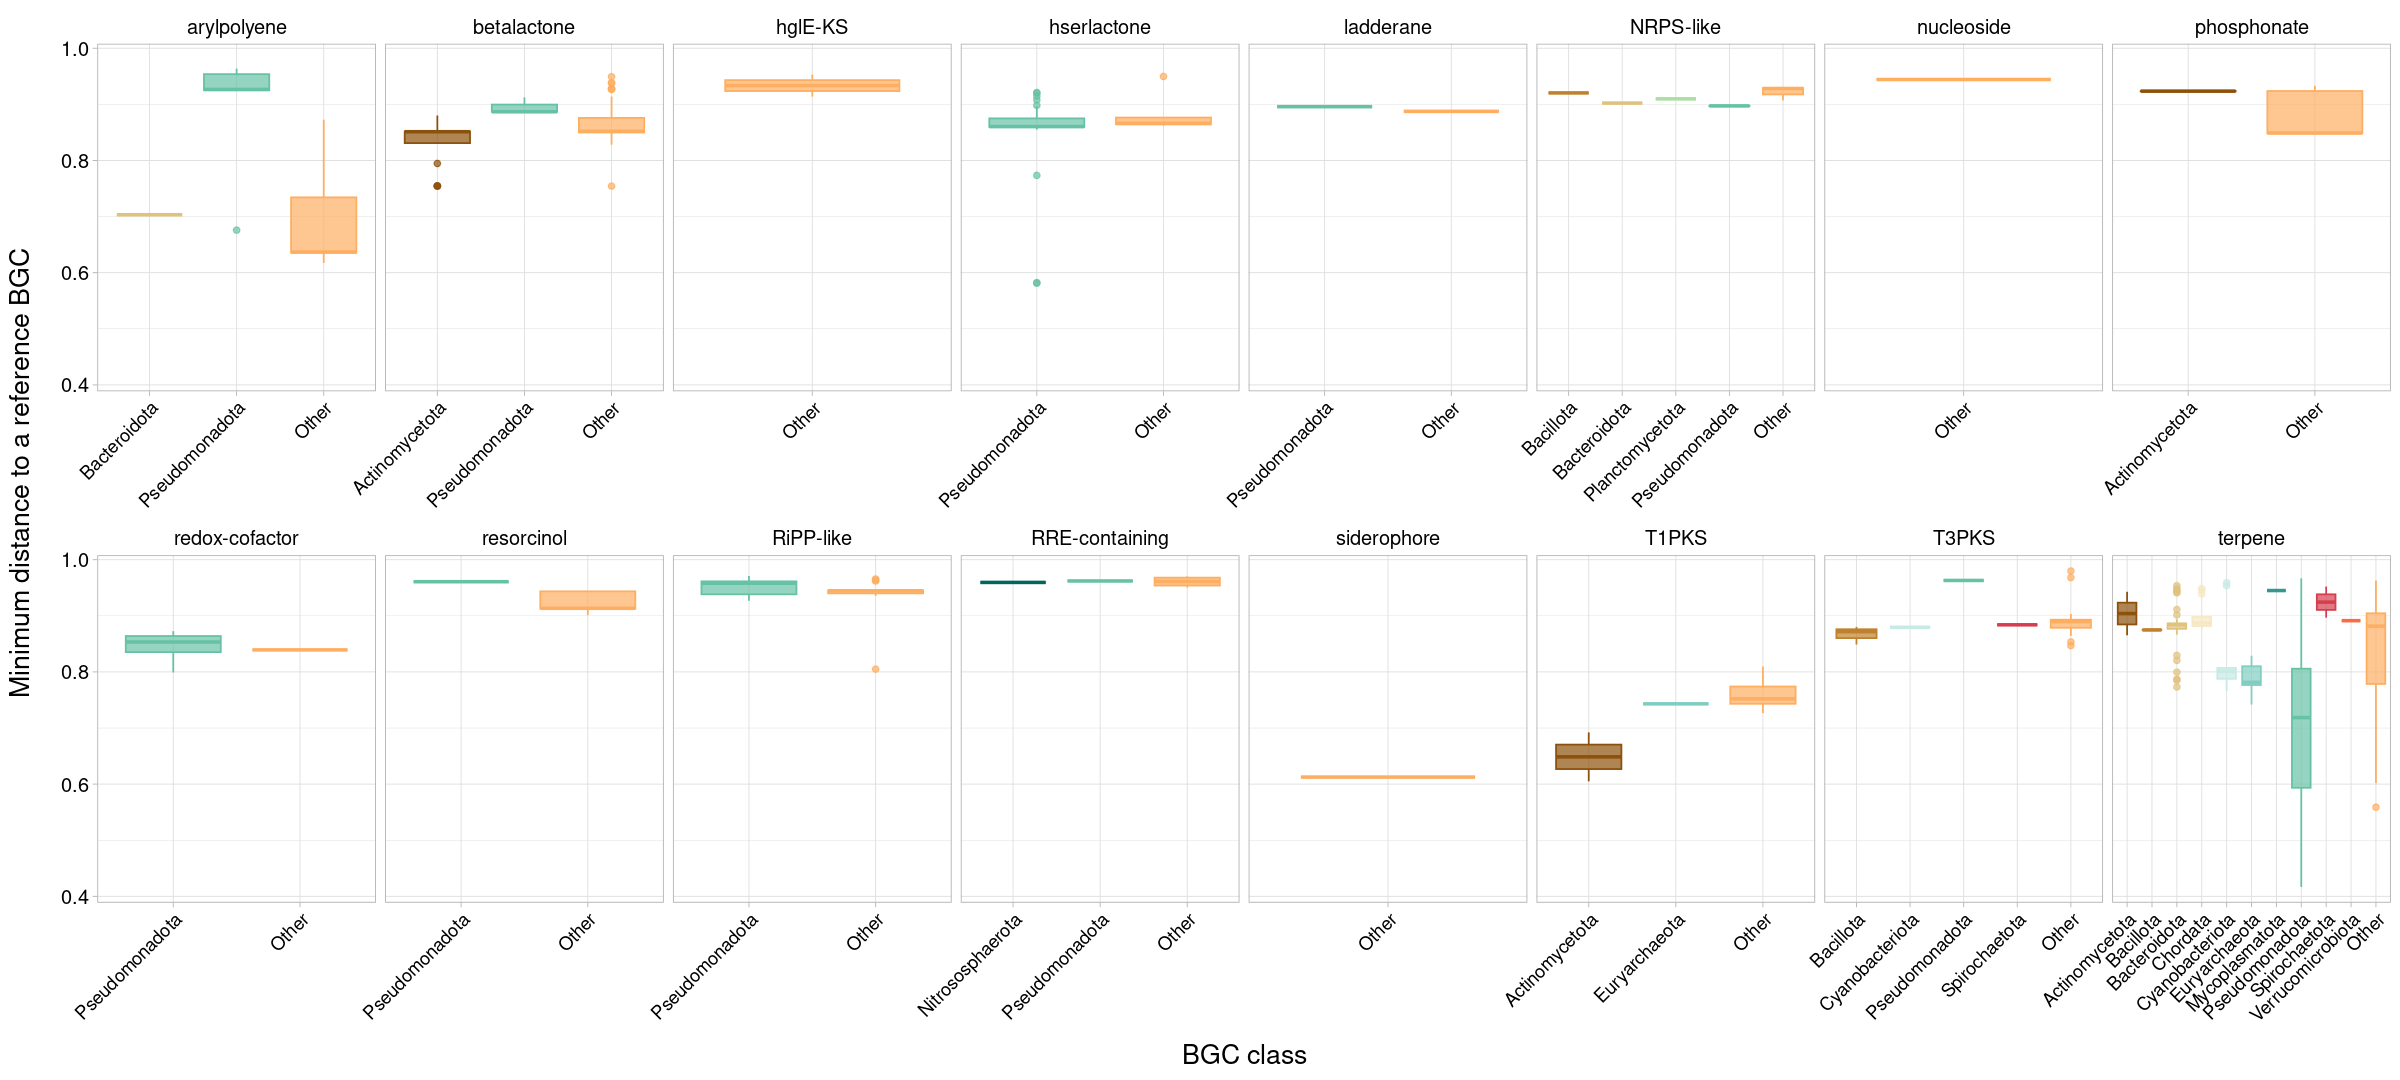

In [388]:
phyla_names <- as.character(unique(BGC_DIST_redu_min_dist$phylum))
i <- phyla_names!="Other"
phyla_names <- c(phyla_names[i][order(phyla_names[i])], "Other")
BGC_DIST_redu_min_dist$phylum <- factor(BGC_DIST_redu_min_dist$phylum, levels = phyla_names)

phyla_colors <- as.character(bgc_colors[1:length(phyla_names)])
names(phyla_colors) <- phyla_names

bgc_novelty_boxplot <- ggplot(BGC_DIST_redu_min_dist, aes(x = phylum, y = `Raw distance`, 
                                                          fill = phylum, color = phylum)) + 
                       facet_wrap(~bgc_class, scales = "free_x", nrow = 2) +
                       geom_boxplot(alpha = 0.7) +
                       # geom_jitter() +
                       xlab("BGC class") +
                       ylab("Minimum distance to a reference BGC") +
                       theme_light() +
                       scale_fill_manual(name="Phylum",
                                         values = phyla_colors) +
                       scale_color_manual(name="Phylum",
                                         values = phyla_colors) +
                       
                       theme( 
                             axis.text.x = element_text(size = text_size -1, angle = 45, hjust = 1, color = "black"),
                             axis.text.y = element_text(size = text_size, color = "black"),
                             axis.title.x = element_text(size = text_size + 4, color = "black",
                                                         margin = margin(10,0,0,0)),
                             axis.title.y = element_text(size = text_size + 4, color = "black",
                                                         margin = margin(0,15,0,0)),
                             strip.background = element_blank(),
                             strip.text = element_text(color = "black", size = text_size),
                             legend.text = element_text(size = text_size +2, color = "black"),
                             legend.title = element_text(size = text_size +4 , color = "black"),
                             legend.position = "none",
                             legend.margin = ggplot2::margin(0,0,-5,0)) +
                        guides(fill = guide_legend(keywidth = 0.6, keyheight = 0.6)) 

options(repr.plot.width=20, repr.plot.height=9)
bgc_novelty_boxplot

Let's do the same considering only the complete BGC sequences. 

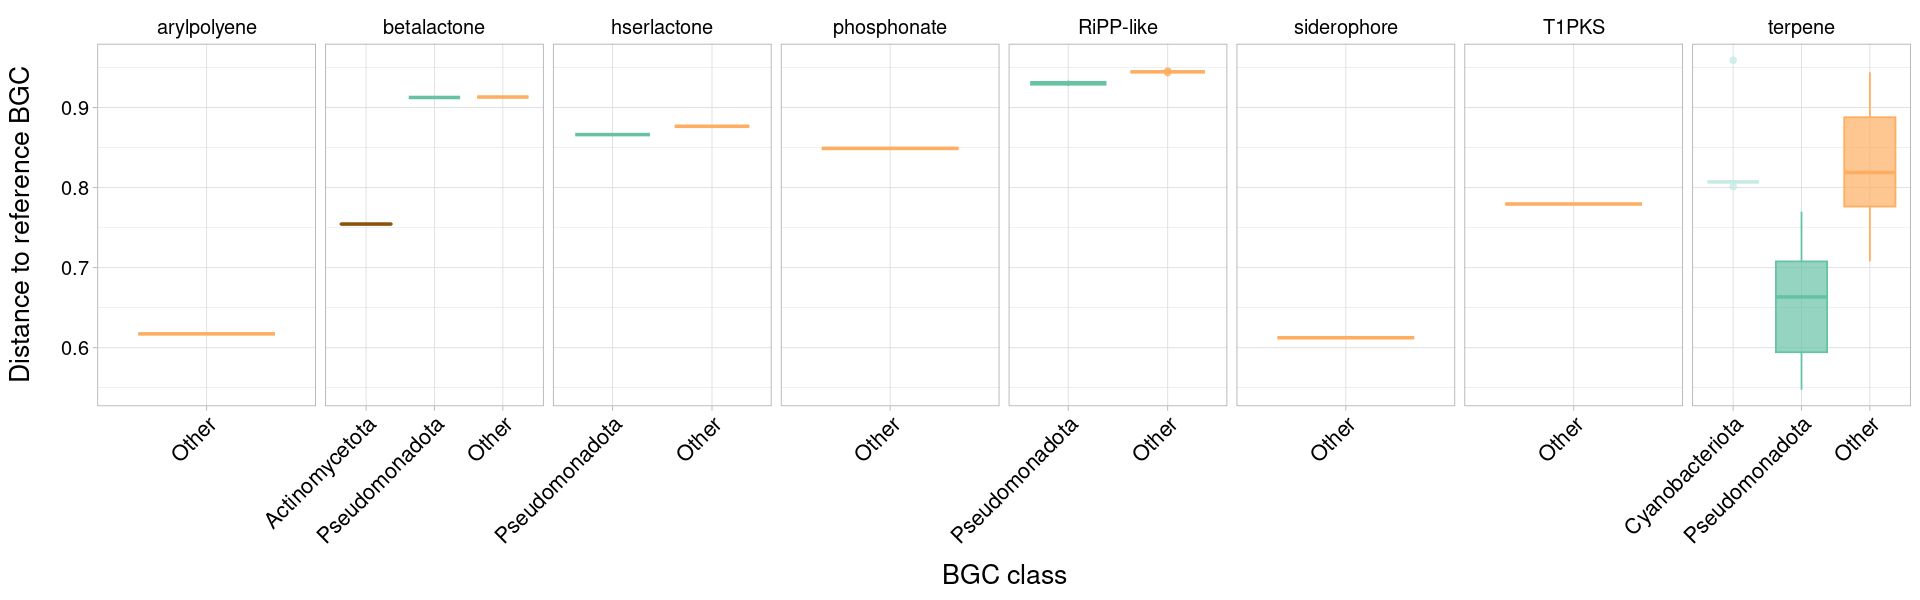

In [390]:
phyla_names <- BGC_DIST_redu_min_dist %>% filter(edge == F) %>% pull(phylum) %>% unique() %>% as.character()

bgc_novelty_boxplot <- ggplot(BGC_DIST_redu_min_dist %>% filter(edge == F), 
                              aes(x = phylum, y = `Raw distance`, fill = phylum, colour = phylum)) + 
                       facet_grid(~bgc_class, scales = "free_x") +
                       geom_boxplot(alpha = 0.7) +
                       xlab("BGC class") +
                       ylab("Distance to reference BGC") +
                       theme_light() +
                       scale_fill_manual(name="Phyla",
                                         values = phyla_colors[phyla_names[order(phyla_names)]]) +
                       scale_color_manual(name="Phyla",
                                          values = phyla_colors[phyla_names[order(phyla_names)]]) +
                       
                       theme( 
                             axis.text.x = element_text(size = text_size +1, angle = 45, hjust = 1, color = "black"),
                             axis.text.y = element_text(size = text_size, color = "black"),
                             axis.title.x = element_text(size = text_size + 4, color = "black",
                                                         margin = margin(10,0,0,0)),
                             axis.title.y = element_text(size = text_size + 4, color = "black",
                                                         margin = margin(0,15,0,0)),
                             strip.background = element_blank(),
                             strip.text = element_text(color = "black", size = text_size),
                             legend.text = element_text(size = text_size +2, color = "black"),
                             legend.title = element_text(size = text_size +4 , color = "black"),
                             legend.position = "none") +
                        guides(fill = guide_legend(keywidth = 0.6, keyheight = 0.6)) 

options(repr.plot.width=16, repr.plot.height=5)
bgc_novelty_boxplot

The RiPPs appear to be an intereseting case: we have seven complete BGC sequences that show a high distnace to knonw reference BGCs from MIBiG.  
We can see which are these reference BGCs with the following command:

In [378]:
BGC_DIST_redu_min_dist %>%
filter(edge == F && bgc_class == "RiPP-like") %>%
pull(`Clustername 1`) %>%
unique()

[1] "BGC0001546.1" "BGC0000550.1"

If we look for these BGCs in [MIBiG database](https://mibig.secondarymetabolites.org/) we can find the compunds that they produce.
Note: BGC0001546 has a new id in MIBiG which is BGC0001485.

[BGC0001546](https://mibig.secondarymetabolites.org/repository/BGC0001485/#r1c1): produces chuangxinmycin which is an antibiotic.  
[BGC0000550](https://mibig.secondarymetabolites.org/repository/BGC0000550/index.html#r1c1): produces salivaricin G32 which is a lantibiotic.